# New TDM client demo

### Download and filter metadata with Pandas

In [73]:
# Parameters:
dataset_id = "80d4487c-cea8-ff65-7e3c-2b37ce7b41d7"


In [74]:
# Importing your dataset with a dataset ID
import tdm_client

dataset_metadata = tdm_client.get_metadata(dataset_id)

INFO:root:Downloading 80d4487c-cea8-ff65-7e3c-2b37ce7b41d7 metadata to 80d4487c-cea8-ff65-7e3c-2b37ce7b41d7.csv


100% |########################################################################|


In [75]:
import pandas as pd

In [76]:
df = pd.read_csv(dataset_metadata)

In [77]:
dataset_document_count = len(df)
print("Total documents", dataset_document_count)

Total documents 650


In [78]:
# Set the pandas option to show all columns
pd.set_option("max_columns", None) 

df.head() # Show the first five rows of our DataFrame

,id,title,isPartOf,publicationYear,doi,docType,provider,datePublished,issueNumber,volumeNumber,url,creator,publisher,language,pageStart,pageEnd,placeOfPublication,wordCount,pageCount,outputFormat
0,http://www.jstor.org/stable/44014892,"Moral Panic, Moral Breach: Bernhard Goetz, Geo...",Social Problems,2016,NaN,article,jstor,2016-02-01,1,63,http://www.jstor.org/stable/44014892,Jennifer Carlson,Oxford University Press,eng,1,20,NaN,12172,20,unigram; bigram; trigram
1,http://www.jstor.org/stable/1290502,(E)racing the Fourth Amendment,Michigan Law Review,2002,NaN,article,jstor,2002-03-01,5,100,http://www.jstor.org/stable/1290502,Devon W. Carbado,The Michigan Law Review Association,eng,946,1044,NaN,51495,99,unigram; bigram; trigram
2,http://www.jstor.org/stable/24480984,"Race in Contemporary America: Protest, Police ...",Economic and Political Weekly,2014,NaN,article,jstor,2014-11-01,43/44,49,http://www.jstor.org/stable/24480984,DIVYA RAVINDRANATH; MAXINE DAVIS; BETH PRUSACZ...,Economic and Political Weekly,eng,22,24,NaN,2615,3,unigram; bigram; trigram
3,http://www.jstor.org/stable/40041293,Property Outlaws,University of Pennsylvania Law Review,2007,NaN,article,jstor,2007-05-01,5,155,http://www.jstor.org/stable/40041293,Eduardo Moisés Peñalver; Sonia K. Katyal,The University of Pennsylvania Law Review,eng,1095,1186,NaN,40548,92,unigram; bigram; trigram
4,http://www.jstor.org/stable/10.5325/utopianstu...,The Anglo-Saxon New Negro: Sutton E. Griggs’s ...,Utopian Studies,2020,NaN,article,jstor,2020-03-01,1,31,http://www.jstor.org/stable/10.5325/utopianstu...,William Tamplin,Penn State University Press,eng,97,117,NaN,7343,21,unigram; bigram; trigram


In [79]:
id_list = df['id'].tolist()

In [80]:
'http://www.jstor.org/stable/2871420' in id_list

False

In [81]:
# Drop each of these named columns
df = df.drop(['outputFormat', 'pageEnd', 'pageStart', 'datePublished', 'language'], axis=1)

In [82]:
# Drop articles without an author
df = df.dropna(subset=['creator'])

In [83]:
print("Total documents", len(df))
print("Original", dataset_document_count)

Total documents 587
Original 650


In [84]:
# Examples for filtering the data based on the values found under 'title'

df = df[df.title != 'Review Article'] # Remove articles with title "Review Article"
df = df[df.title != 'Front Matter'] # Remove articles with title "Front Matter"
df = df[df.title != 'Back Matter'] # Remove articles with title "Back Matter"

# Remove articles with fewer than 3000 words, adjust or remove

df = df[df.wordCount > 3000] 

In [85]:
print("Total documents", len(df))
print("Original", dataset_document_count)

Total documents 579
Original 650


In [86]:
filtered_id_list = df["id"].tolist()

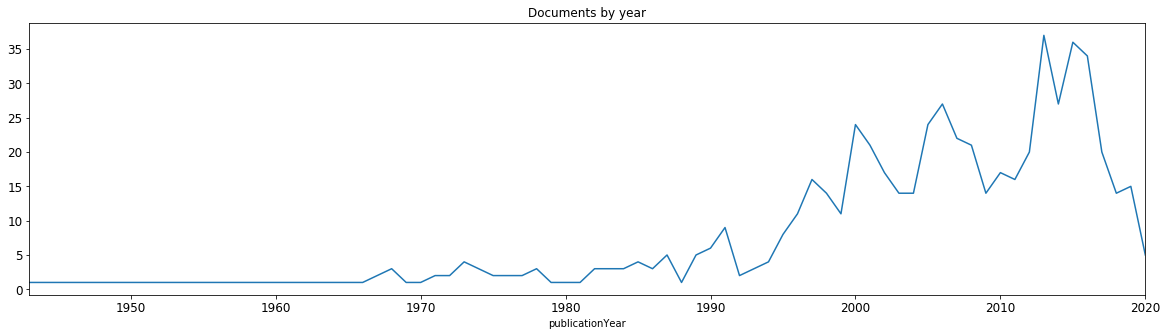

In [87]:
df.groupby(['publicationYear'])['id'].agg('count').plot.line(title='Documents by year', figsize=(20, 5), fontsize=12); 

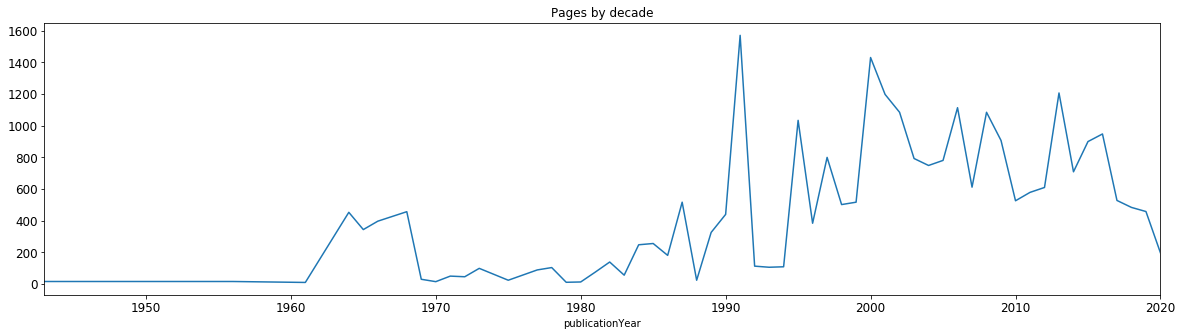

In [88]:
df.groupby(['publicationYear'])['pageCount'].agg('sum').plot.line(title='Pages by decade', figsize=(20, 5), fontsize=12);

### Count word frequencies

In [89]:
dataset_json_file = tdm_client.get_dataset(dataset_id)

INFO:root:Downloading 80d4487c-cea8-ff65-7e3c-2b37ce7b41d7 to 80d4487c-cea8-ff65-7e3c-2b37ce7b41d7.jsonl.gz


100% |########################################################################|


In [90]:
import json
import gzip
from collections import Counter

word_frequency = Counter()

In [91]:
with gzip.open(dataset_json_file, "rb") as input_file:
    for row in input_file:
        document = json.loads(row)
        _id = document["id"]
        if _id in filtered_id_list:
            unigrams = document.get("unigramCount", [])
            for gram, count in unigrams.items():
                word_frequency[gram] += count

In [92]:
for gram, count in word_frequency.most_common(25):
    print(gram.ljust(20), count)

the                  643877
of                   477384
and                  370221
to                   258748
in                   249272
a                    181952
that                 133893
for                  86922
The                  82569
by                   78710
as                   76915
at                   71099
is                   69878
on                   67241
was                  53559
with                 52530
not                  44748
from                 41170
be                   37856
an                   37298
or                   36963
it                   33470
are                  32695
their                31715
were                 29984


In [93]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [94]:
transformed_word_frequency = Counter()

In [95]:
for document in tdm_client.dataset_reader(dataset_json_file):
    _id = document["id"]
    if _id in filtered_id_list:
        unigrams = document.get("unigramCount", [])
        for gram, count in unigrams.items():
            clean_gram = gram.lower()
            if clean_gram in stop_words:
                continue
            transformed_word_frequency[clean_gram] += count
        break

In [96]:
for gram, count in transformed_word_frequency.most_common(25):
    print(gram.ljust(20), count)

freedom              119
mtm:                 68
sn:                  68
riders               60
bus                  43
film                 43
e                    39
black                36
it’s                 36
that’s               36
people               35
white                32
going                29
one                  28
civil                27
r                    26
n                    26
h                    26
rights               25
we’re                25
don’t                24
make                 22
think                22
i’m                  22
story                22


In [97]:
df = pd.DataFrame(list(transformed_word_frequency.items())[:25], columns=["ngram", "count"])

In [98]:
df.head()

,ngram,count
0,freedom,119
1,mtm:,68
2,sn:,68
3,riders,60
4,bus,43


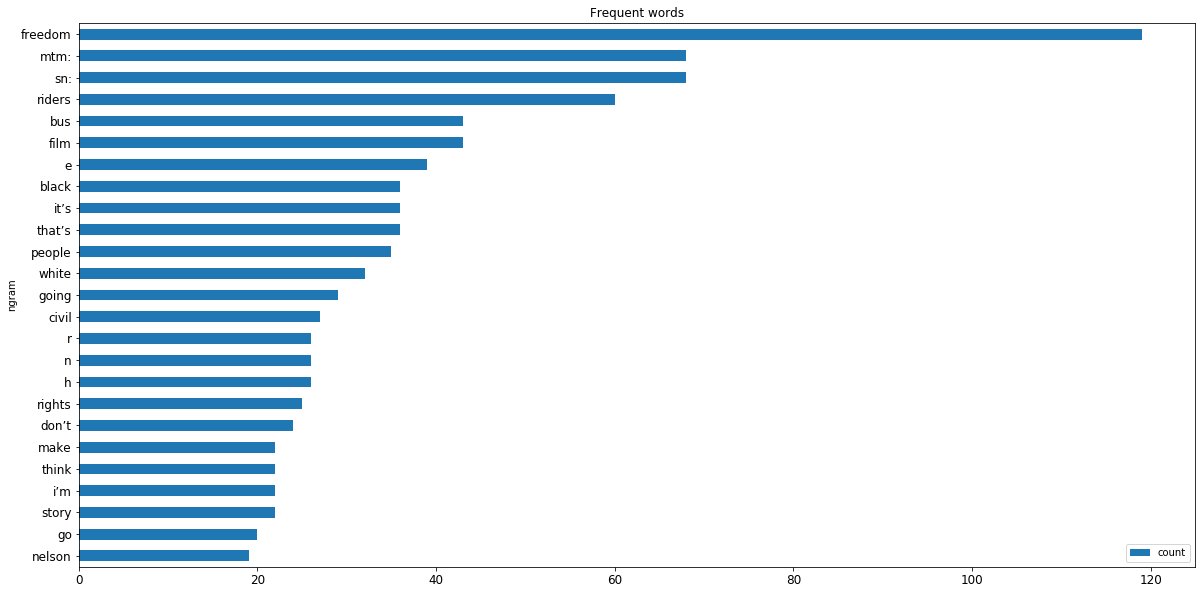

In [99]:
df.sort_values('count', ascending=True).plot.barh(title='Frequent words', figsize=(20, 10), fontsize=12, x="ngram", y="count");

### Significant terms

Run TFIDF on the first 10 documents in the filtered corpus.

In [100]:
def process_token(token):
    token = token.lower()
    if token in stop_words:
        return
    if len(token) < 4:
        return
    if not(token.isalpha()):
        return
    return token

In [101]:
import gensim

In [102]:
n = 0
documents = []
for document in tdm_client.dataset_reader(dataset_json_file):
    processed_document = []
    _id = document["id"]
    if _id in filtered_id_list:
        unigrams = document.get("unigramCount", [])
        for gram, count in unigrams.items():
            clean_gram = process_token(gram)
            if clean_gram is None:
                continue
            processed_document.append(clean_gram)
        if len(processed_document) > 0:
            documents.append(processed_document)
        n += 1
        #if n >= 10:
        #    break

In [103]:
dictionary = gensim.corpora.Dictionary(documents)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(158785 unique tokens: ['able', 'abstract', 'academy', 'accompanying', 'accomplishment']...) from 579 documents (total 1742231 corpus positions)


In [104]:
dict(list(dictionary.token2id.items())[0:10]) # Print the first ten tokens and their associated IDs.


{'able': 0,
 'abstract': 1,
 'academy': 2,
 'accompanying': 3,
 'accomplishment': 4,
 'accosted': 5,
 'account': 6,
 'accused': 7,
 'accuses': 8,
 'across': 9}

In [105]:
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]

In [106]:
model = gensim.models.TfidfModel(bow_corpus)

INFO:gensim.models.tfidfmodel:collecting document frequencies
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #0
INFO:gensim.models.tfidfmodel:calculating IDF weights for 579 documents and 158785 features (1592833 matrix non-zeros)


In [107]:
corpus_tfidf = model[bow_corpus]

In [108]:
rows = []
for doc in corpus_tfidf:
    for term_id, score in doc:
        rows.append([dictionary.get(term_id), score])

In [109]:
df = pd.DataFrame(rows, columns=["ngram", "score"])

In [110]:
df.head()

,ngram,score
0,able,0.003105
1,abstract,0.014882
2,academy,0.019287
3,accompanying,0.015244
4,accomplishment,0.032323


In [111]:
df.describe()

,score
count,1.592833e+06
mean,1.441363e-02
std,1.248001e-02
min,2.671869e-06
25%,5.687360e-03
50%,1.052550e-02
75%,1.928231e-02
max,2.717892e-01


In [112]:
top_50 = df.sort_values("score", ascending=False).head(n=50)

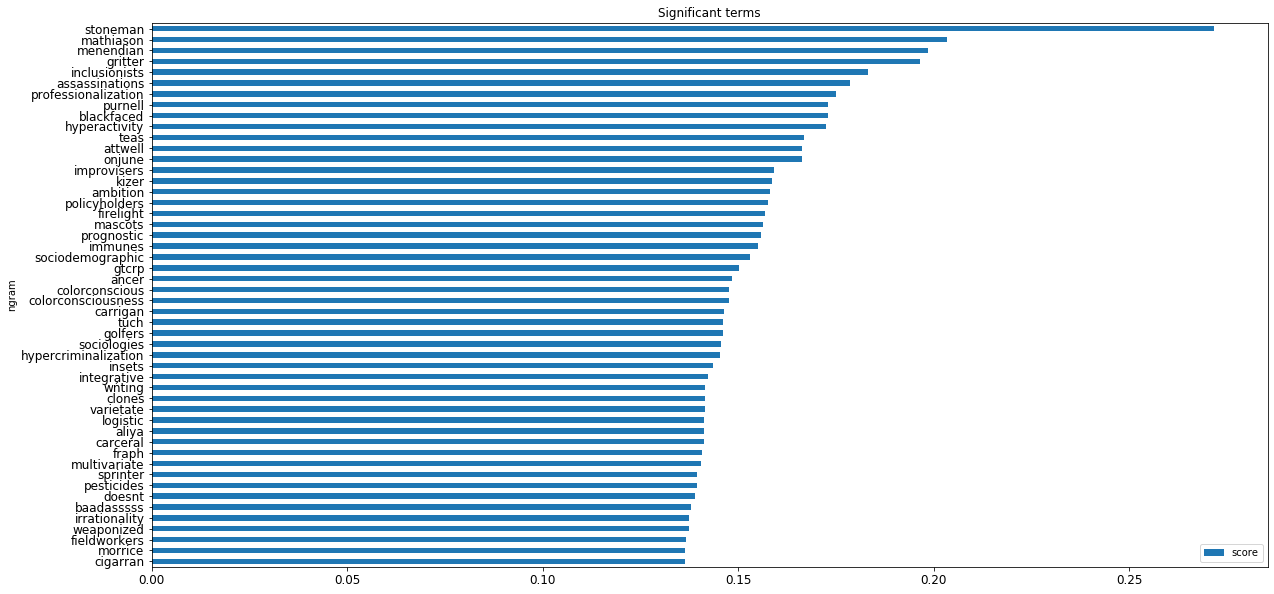

In [113]:
top_50.sort_values("score", ascending=True).plot.barh(title='Significant terms', figsize=(20, 10), fontsize=12, x="ngram", y="score");

 ### LDA topic modeling

In [114]:
doc_count = len(id_list)
num_topics = 7 # Change the number of topics

# Remove terms that appear in less than 10% of documents and more than 75% of documents.
dictionary.filter_extremes(no_below=10 * .10, no_above=0.75)


INFO:gensim.corpora.dictionary:discarding 58785 tokens: [('able', 450), ('across', 471), ('action', 461), ('african', 498), ('along', 476), ('also', 576), ('although', 493), ('always', 459), ('america', 473), ('american', 578)]...
INFO:gensim.corpora.dictionary:keeping 100000 tokens which were in no less than 1 and no more than 434 (=75.0%) documents
INFO:gensim.corpora.dictionary:resulting dictionary: Dictionary(100000 unique tokens: ['abstract', 'academy', 'accompanying', 'accomplishment', 'accosted']...)


In [115]:
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]

In [116]:
# Train the LDA model.
model = gensim.models.LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=num_topics
)

INFO:gensim.models.ldamodel:using symmetric alpha at 0.14285714285714285
INFO:gensim.models.ldamodel:using symmetric eta at 0.14285714285714285
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (single-pass) LDA training, 7 topics, 1 passes over the supplied corpus of 579 documents, updating model once every 579 documents, evaluating perplexity every 579 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:-12.417 per-word bound, 5469.0 perplexity estimate based on a held-out corpus of 579 documents with 1545176 words
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #579/579
INFO:gensim.models.ldamodel:topic #2 (0.143): 0.000*"culture" + 0.000*"freedom" + 0.000*"urban" + 0.000*"court" + 0.000*"department" + 0.000*"policy" + 0.000*"using" + 0.000*"family" + 0.000*"review" + 0.000*"relations"
INFO:gensim.models.ldamodel:topic #5 (0.143): 0.001*"federal" + 0.000*"urban" + 0.000*"co

In [117]:
for topic_num in range(0, num_topics):
    word_ids = model.get_topic_terms(topic_num)
    words = []
    for wid, weight in word_ids:
        word = dictionary.id2token[wid]
        words.append(word)
    print("Topic {}".format(str(topic_num).ljust(5)), " ".join(words))

Topic 0     court freedom color cultural research century equal open report rise
Topic 1     court report review culture labor critical analysis modern federal board
Topic 2     culture freedom urban court department policy using family review relations
Topic 3     death perhaps federal report line instead notes department cultural research
Topic 4     criminal perhaps cultural president review instead century citizens fight relations
Topic 5     federal urban court report problems theory modern process press special
Topic 6     education federal research urban court instead press cultural beginning taking
